This dataset is from Global Terrorism Database curated by the University of Maryland:

National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2018). Global Terrorism Database [Data file]. Retrieved from https://www.start.umd.edu/gtd.

In dividing and classifying the city names within the data-set, __[this article from the New York Times](https://www.nytimes.com/interactive/2016/01/04/world/middleeast/sunni-shiite-map-middle-east-iran-saudi-arabia.html)__ was instrumental as was __[this website](http://zakhor-online.com/?attachment_id=7932)__ and __[this one.](https://www.vox.com/a/maps-explain-the-middle-east)__
__[and this one too](http://gulf2000.columbia.edu/maps.shtml)__ https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/63-colombias-armed-groups-battle-spoils-peace#map-5700-8

In this notebook, we will try and isolate data related to cyber-warfare or hacking events.

In [235]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 1. Importing, Cleaning and General Overview:

#### A. Importing Data.

In [237]:
df = pd.read_excel('globalterrorismdb_0718dist.xlsx', 
                   usecols = 'A:D, F, H:M, S:W, AA:AD, AI:AN, AP, BG, BM:BN, BQ:BR, CD:CG, DA',
                   dtype = {'summary':str, 'motive':str})                                                                                         

In [238]:
# Renaming for usability:

cyber_data = pd.DataFrame(df.rename({'eventid':'event_id', 'iyear':'year', 'imonth':'month',
             'iday':'day', 'extended':'24+hrs', 'provstate':'region_2', 'doubtterr':'doubt', 
             'attacktype1':'attack_1', 'attacktype1_txt':'attack_1txt','attacktype2':'attack_2', 
             'targtype1':'target_1', 'targtype1_txt':'target_1txt', 'targsubtype1':'sub_target',
             'targsubtype1_txt':'sub_targettxt', 'target1':'specific_target',
             'natlty1':'victim_nationality', 'natlty1_txt':'victim_nationalitytxt', 'gname':'group_name', 
             'guncertain1':'group_attrib_crtainty', 'individual':'unaffil_individ', 'weaptype1':'weapon', 
             'weaptype1_txt':'weapontxt', 'weapsubtype1':'sub_weapon', 'weapsubtype1_txt':'sub_weapontxt'}, axis = 1))

#### B. Selecting Rows Specific to Our Question (cyber_data):


In [239]:
# Creating the dyber_cyber_train_input Dataframe:
# Regex to isolate qualifying data (This set is more flexible in its Regex):
import re
import gc

print(cyber_data.summary.str.contains('cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+',
                         flags = re.IGNORECASE, regex = True).value_counts())

# Creating a mask which represents the results from our search above:

mask = cyber_data.summary.str.contains(r'(cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+)', 
                           flags = re.IGNORECASE)

# Creating a new, filtered dataframe with this specific information:

cyber_data = pd.DataFrame(cyber_data[mask])

False    172205
True       9486
Name: summary, dtype: int64


#### C. Splitting Our Train/Test Data (cyber_train/test_X / cyber_train/test_Y):

In [240]:
from sklearn.model_selection import cross_val_score, train_test_split

In [241]:
# Defining our Input and Output:
# Cleaning later to prevent leakage.

X = cyber_data.drop(['event_id', 'success', 'summary', 'motive'], axis = 1)
Y = pd.DataFrame(cyber_data['success'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .25)

X_train_start_index = X_train.index
X_test_start_index = X_test.index

#### D. Isolating Columns:

> We want to be sure we are only using the numeric columns that are significant and not arbitrary categoricals:

In [242]:
# Dropping irrelevant columns from training set input and putting it into a datafarme:

cyber_train_X = X_train[['24+hrs', 'country_txt', 'region_txt', 'city', 'crit1', 'crit2', 'crit3',
                             'doubt', 'suicide', 'attack_1txt', 'target_1txt', 'sub_targettxt', 
                             'specific_target', 'victim_nationalitytxt', 'group_name', 'group_attrib_crtainty', 
                             'unaffil_individ', 'weapontxt', 'sub_weapontxt']]

# Making sure these dropped rows are not in the training output column (i.e. making sure our input and output cyber_train_inputs
# have the same amount of rows):

# cyber_train_input_index = cyber_train_input.index same as X_train_start_index

cyber_train_Y = Y_train.iloc[Y_train.index == cyber_train_X.index]

In [243]:
# Applying the same process above to our test data:

cyber_test_X = X_test[['24+hrs', 'country_txt', 'region_txt', 'city', 'crit1', 'crit2', 'crit3',
                             'doubt', 'suicide', 'attack_1txt', 'target_1txt', 'sub_targettxt', 
                             'specific_target', 'victim_nationalitytxt', 'group_name', 'group_attrib_crtainty', 
                             'unaffil_individ', 'weapontxt', 'sub_weapontxt']]

# Making sure these dropped rows are not in the testing output column (i.e. making sure our input and output cyber_test_inputs
# have the same amount of rows):

# cyber_test_input_index = cyber_test_input.index (same as X_test index)

cyber_test_Y = Y_test.iloc[Y_test.index == cyber_test_X.index]

#### E. Applying Filters to Text Columns.

> Doing this mainly in the hopes of allowing us to get dummies on certain features which is small enough to use for explanatory purposes (i.e. avoiding a feature set with thousands of columns).

##### Weapontxt:

> ###### Training Input:

In [244]:
# Grouping Biological and Chemical Weapons:
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace('Chemical', 'Bio-Chem')
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace('Biological', 'Bio-Chem')

# Grouping Fake and Other together:
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace('Fake Weapons', 'Fake/Other')
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace('Other', 'Fake/Other')

# Aggregating Vehicle into Sabotage Equipment:
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Sabotage Equipment')


> ###### Test Input:

In [245]:
# Grouping Biological and Chemical Weapons:
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace('Chemical', 'Bio-Chem')
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace('Biological', 'Bio-Chem')

# Grouping Fake and Other together:
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace('Fake Weapons', 'Fake/Other')
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace('Other', 'Fake/Other')

# Aggregating Vehicle into Sabotage Equipment:
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Sabotage Equipment')


##### Sub_targettxt:

> ###### Training Input:

In [246]:
industrial = ['Gas/Oil/Electric', 'Industrial/Textiles/Factory', 'Farm/Ranch', 'Mining', 'Construction']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in industrial), 
                                     other = 'Industrial')


white_collar = ['Restaurant/Bar/Café', 'Bank/Commerce', 'Multinational Corporation', 
                'Medical/Pharmaceutical', 'Retail/Grocery/Bakery (including cell phone shops and generic shops)', 
                'Hotel/Resort', 'Entertainment/Cultural/Stadium/Casino', 'Private Security Company/Firm',
                'Legal Services']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in white_collar), 
                                     other = 'White_Collar')


gov_figure1 = ['Judges/Attorneys/Courts', 'Government Personnel (excluding police, military)']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in gov_figure1), 
                                     other = 'Gov_Figure1')

gov_figure2 = ['Politician or Political Party Movement/Meeting/Rally', 'Royalty', 'Head of State',
               'Election-Related']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Gov_Figure2')


police_facilities = ['Police Buildings (Headquarters/Stations/School)', 
                     'Police Patrol (including vehicles and convoys)', 
                     'Police Checkpoint', 'Prison/Jail']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Police_Facilities')

military_facilities = ['Military Barracks/Base/Headquarters/Checkpost', 'Military Recruiting Station/Academy',
                       'Military Weaponry', 'Military Aircraft', 'Military Maritime', 
                       'Military Transportation/Vehicle (excluding convoys)', 'Military Checkpoint',
                       'Paramilitary']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in military_facilities), 
                                     other = 'Military_Facilities')


military_personnel = ['Military Unit/Patrol/Convoy', 'Non-combatant Personnel', 
                      'Military Personnel (soldiers, troops, officers, forces)']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Military_Personnel')


pilots_aircraft = ['Aircraft (not at an airport)', 'Airline Officer/Personnel']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')

gov_diplomatic = [' Diplomatic Personnel (outside of embassy, consulate)', 'Embassy/Consulate', 
                  'International Organization (peacekeeper, aid agency, compound)']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in gov_diplomatic), 
                                     other = 'Gov_Diplomatic')

educational = ['Teacher/Professor/Instructor', 'School/University/Educational Building', 
               'Other Personnel']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in educational), 
                                     other = 'Educational')

food_water = ['Food Supply', 'Water Supply']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in food_water), 
                                     other = 'Food_Water')

media = ['Newspaper Journalist/Staff/Facility', 'Radio Journalist/Staff/Facility', 
         'Television Journalist/Staff/Facility', 'Other (including online news agencies)']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in media), 
                                     other = 'Media')


religious = ['Religion Identified', 'Religious Figure', 'Place of Worship', 
             'Affiliated Institution']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')


political = ['Protrainer', 'Political Party Member/Rally', 'Party Official/Candidate/Other Personnel', 
             'Party Office/Facility', 'Rally']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in political), 
                                     other = 'Political')

mass_socio = ['Refugee (including Camps/IDP/Asylum Seekers)', 'Named Civilian', 'Student', 
              'Race/Ethnicity Identified', 'Farmer', 'Vehicles/Transportation', 'Marketplace/Plaza/Square', 'Village/City/Town/Suburb', 
              'House/Apartment/Residence', 'Laborer (General)/Occupation Identified', 'Procession/Gathering (funeral, wedding, birthday, religious)', 
              'Public Areas (e.g., Public garden, parking lot, garage, beach, public buildings, camps)',
             'Memorial/Cemetery/Monument', 'Museum/Cultural Center/Cultural House', 'Labor Union Related', 
              'Tourism Travel Agency', 'Tour Bus/Van/Vehicle', 'Tourist', 'Other Facility', 'train/train Tracks/ Trolley', 'Bus Station/Stop', 'Subway', 
              'Bridge/Car Tunnel', 'Highway/Road/Toll/Traffic Signal', 'Taxi/Rickshaw']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in mass_socio), 
                                     other = 'Mass_Social')



util_telecom = ['Radio', 'Television', 'Telephone/Telegraph', 'Internet Infrastructure', 
                'Multiple Telecommunication Targets', 'Gas', 'Electricity', 'Oil']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in util_telecom), 
                                     other = 'Util_Telecom')

> ###### Test Data:

In [247]:
# Test Data:

industrial = ['Gas/Oil/Electric', 'Industrial/Textiles/Factory', 'Farm/Ranch', 'Mining', 'Construction']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in industrial), 
                                     other = 'Industrial')


white_collar = ['Restaurant/Bar/Café', 'Bank/Commerce', 'Multinational Corporation', 
                'Medical/Pharmaceutical', 'Retail/Grocery/Bakery (including cell phone shops and generic shops)', 
                'Hotel/Resort', 'Entertainment/Cultural/Stadium/Casino', 'Private Security Company/Firm',
                'Legal Services']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in white_collar), 
                                     other = 'White_Collar')


gov_figure1 = ['Judges/Attorneys/Courts', 'Government Personnel (excluding police, military)']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in gov_figure1), 
                                     other = 'Gov_Figure1')

gov_figure2 = ['Politician or Political Party Movement/Meeting/Rally', 'Royalty', 'Head of State',
               'Election-Related']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Gov_Figure2')


police_facilities = ['Police Buildings (Headquarters/Stations/School)', 
                     'Police Patrol (including vehicles and convoys)', 
                     'Police Checkpoint', 'Prison/Jail']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Police_Facilities')

military_facilities = ['Military Barracks/Base/Headquarters/Checkpost', 'Military Recruiting Station/Academy',
                       'Military Weaponry', 'Military Aircraft', 'Military Maritime', 
                       'Military Transportation/Vehicle (excluding convoys)', 'Military Checkpoint',
                       'Paramilitary']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in military_facilities), 
                                     other = 'Military_Facilities')


military_personnel = ['Military Unit/Patrol/Convoy', 'Non-combatant Personnel', 
                      'Military Personnel (soldiers, troops, officers, forces)']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Military_Personnel')


pilots_aircraft = ['Aircraft (not at an airport)', 'Airline Officer/Personnel']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')

gov_diplomatic = [' Diplomatic Personnel (outside of embassy, consulate)', 'Embassy/Consulate', 
                  'International Organization (peacekeeper, aid agency, compound)']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in gov_diplomatic), 
                                     other = 'Gov_Diplomatic')

educational = ['Teacher/Professor/Instructor', 'School/University/Educational Building', 
               'Other Personnel']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in educational), 
                                     other = 'Educational')

food_water = ['Food Supply', 'Water Supply']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in food_water), 
                                     other = 'Food_Water')

media = ['Newspaper Journalist/Staff/Facility', 'Radio Journalist/Staff/Facility', 
         'Television Journalist/Staff/Facility', 'Other (including online news agencies)']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in media), 
                                     other = 'Media')


religious = ['Religion Identified', 'Religious Figure', 'Place of Worship', 
             'Affiliated Institution']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')


political = ['Protester', 'Political Party Member/Rally', 'Party Official/Candidate/Other Personnel', 
             'Party Office/Facility', 'Rally']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in political), 
                                     other = 'Political')

mass_socio = ['Refugee (including Camps/IDP/Asylum Seekers)', 'Named Civilian', 'Student', 
              'Race/Ethnicity Identified', 'Farmer', 'Vehicles/Transportation', 'Marketplace/Plaza/Square', 'Village/City/Town/Suburb', 
              'House/Apartment/Residence', 'Laborer (General)/Occupation Identified', 'Procession/Gathering (funeral, wedding, birthday, religious)', 
              'Public Areas (e.g., Public garden, parking lot, garage, beach, public buildings, camps)',
             'Memorial/Cemetery/Monument', 'Museum/Cultural Center/Cultural House', 'Labor Union Related', 
              'Tourism Travel Agency', 'Tour Bus/Van/Vehicle', 'Tourist', 'Other Facility', 'test/test Tracks/ Trolley', 'Bus Station/Stop', 'Subway', 
              'Bridge/Car Tunnel', 'Highway/Road/Toll/Traffic Signal', 'Taxi/Rickshaw']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in mass_socio), 
                                     other = 'Mass_Social')



util_telecom = ['Radio', 'Television', 'Telephone/Telegraph', 'Internet Infrastructure', 
                'Multiple Telecommunication Targets', 'Gas', 'Electricity', 'Oil']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in util_telecom), 
                                     other = 'Util_Telecom')

##### Group_name:

> Trying Group_name a bit and grouping them by Ideaology.

> ###### Training Input:

In [248]:
# Separatists, Leftists and Rightists:

# Palestinian Separatists:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hamas (Islamic Resistance Movement)', 
                                                        'Palestinian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Palestinian Islamic Jihad (PIJ)', 
                                                        'Palestinian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Popular Front for the Liberation of Palestine (PFLP)',
                                                        'Palestinian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Popular Resistance Committees',
                                                        'Palestinian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Fatah',
                                                        'Palestinian_Separatists')

# Militants:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Militants',
                                                        'Militant_Gunmen_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Gunmen',
                                                        'Militant_Gunmen_Groups')

In [249]:
# Asian Separatists:

cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Abu Sayyaf Group (ASG)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Colonel Karuna Faction',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Eastern Turkistan Islamic Movement (ETIM)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Free Aceh Movement (GAM)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Janatantrik Terai Mukti Morcha (Jtmm)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Goit (Jtmm-G)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Jwala Singh (Jtmm-J)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Rajan Mukti (Jtmm-R)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Liberation Tigers of Tamil Eelam (LTTE)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Moro Islamic Liberation Front (MILF)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Runda Kumpulan Kecil (Rkk)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Terai Army',
                                                        'Asian_Separatists')

In [250]:
# Middle Eastern Separatists
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Supreme Council For Islamic Revolution In Iraq (Sciri)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Southern Mobility Movement (Yemen)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Riyadus-Salikhin Reconnaissance And Sabotage Battalion Of Chechen Martyrs',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Haqqani Network',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Harkatul Jihad-E-Islami',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hizbul Mujahideen (Hm)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jaish-E-Mohammad (Jem)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kurdistan Free Life Party',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kurdistan Workers\' Party (PKK)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Lashkar-E-Balochistan',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Lashkar-E-Taiba (Let)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Liberation Front (Blf)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Free Syrian Army',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Chechen Rebels',
                                                        'Middle_Eastern_Separatists')

In [251]:
# Indian Separatists
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Black Widows',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Dima Halao Daoga (Dhd)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Garo National Liberation Army',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kangleipak Communist Party (KCP)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Karbi Longri North Cachar Liberation Front (Klnlf)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Democratic Front of Bodoland (NDFB)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Liberation Front of Tripura (NLFT)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('People\'s Liberation Army (PLA)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('People\'s Revolutionary Party of Kangleipak (PREPAK)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('United Liberation Front of Assam (ULFA)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('United National Liberation Front (UNLF)',
                                                        'Indian_Separatists')

In [252]:
# NW_Indian_Groups:

cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Lashkar-e-Jhangvi',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Sipah-e-Sahaba/Pakistan (SSP)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hizbul Mujahideen (HM)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Liberation Front (BLF)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Young Tigers (BYT)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Young Tigers (BYT)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('United Baloch Army (UBA)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Free Balochistan Army (FBA)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Nationalists',
                                                        'NW_Indian_Groups')

In [253]:
# SE_Indian_Groups:

cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Communist Party of India - Maoist (CPI-Maoist)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Indian Mujahideen',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jama\'atul Mujahideen Bangladesh (JMB)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Bangladesh Sarbahara Party',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Purbo Banglar Communist Party',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Harkatul Jihad-e-Islami',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hynniewtrep National Liberation Council (HNLC)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kanglei Yawol Kanna Lup (KYKL)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kuki Tribal Militants',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kuki National Front (KNF)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('United Kuki Liberation Front (UKLF) - India',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hill Tiger Force (HTF)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Socialist Council of Nagaland-Khaplang (NSCN-K)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Socialist Council of Nagaland-Unification (NSCN-U)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('',
                                                        'SE_Indian_Groups')

In [254]:
# African Political:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Union for the Total Independence of Angola (UNITA)',
                                                         'African_Political')

In [255]:
# Irish Separatists
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Real Irish Republican Army (RIRA)',
                                                        'Irish_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Oglaigh Na Heireann',
                                                        'Irish_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Irish Republican Army (IRA)',
                                                        'rish_Separatists')


In [256]:
# Farc left and right
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Liberation Army of Colombia (ELN)',
                                                        'FARC_Leftist')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Popular Liberation Army (EPL)',
                                                        'FARC_Leftist')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Revolutionary Armed Forces of Colombia (FARC)',
                                                        'FARC_Leftist')

cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('United Self Defense Units of Colombia (AUC)',
                                                        'FARC_Rightist')
  

In [257]:
# Middle Eastern Religious:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Gama\'at Al-Islamiyya (IG)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Nusrah Front',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qa\'ida',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qa\'ida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qa\'ida in the Lands of the Islamic Maghreb (AQLIM)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Shabaab',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Asa\'Ib Ahl Al-Haqq',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Eritrean Islamic Jihad Movement (EIJM)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Great Eastern Islamic Raiders Front (Ibda-C)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hizbul Al Islam (Somalia)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Islamic Courts Union (ICU)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Islamic State of Iraq and al Sham (ISIS)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Islamic Movement of Uzbekistan (IMU)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jamiat Ul-Mujahedin (Jum)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jundallah',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Mahdi Army',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Taliban',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Tehrik-i-Taliban Pakistan (TTP)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Armed Islamic Group (GIA)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Sunni Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qaida in the Islamic Maghreb (AQIM)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Islamic State of Iraq and the Levant (ISIL)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qaida in Iraq',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qaida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qaida',
                                                        'Middle_Eastern_Religious')

In [258]:
# Israeli, Palestinian, Lebanese Religious:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Anti-Semitic extremists',
                                                        'Near_Israel_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hezbollah',
                                                        'Near_Israel_Religious')

In [259]:
# Asian and African Religious:

cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Students Islamic Movement of India (Simi)',
                                                        'Asian/Asian-Pacific_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ranbir Sena',
                                                        'Asian/Asian-Pacific_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jemaah Islamiya (JI)',
                                                        'Asian/Asian-Pacific_Religious')


cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Movement for Oneness and Jihad in West Africa (MUJAO)',
                                                        'African_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Lord\'s Resistance Army (LRA)',
                                                        'African_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Boko Haram',
                                                        'African_Religious')


> ###### Test Input:

In [260]:
# Separatists, Leftists and Rightists:

# Palestinian Separatists:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hamas (Islamic Resistance Movement)', 
                                                        'Palestinian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Palestinian Islamic Jihad (PIJ)', 
                                                        'Palestinian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Popular Front for the Liberation of Palestine (PFLP)',
                                                        'Palestinian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Popular Resistance Committees',
                                                        'Palestinian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Fatah',
                                                        'Palestinian_Separatists')

# Militants:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Militants',
                                                        'Militant_Gunmen_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Gunmen',
                                                        'Militant_Gunmen_Groups')

In [261]:
# Asian Separatists:

cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Abu Sayyaf Group (ASG)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Colonel Karuna Faction',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Eastern Turkistan Islamic Movement (ETIM)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Free Aceh Movement (GAM)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Janatantrik Terai Mukti Morcha (Jtmm)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Goit (Jtmm-G)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Jwala Singh (Jtmm-J)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Rajan Mukti (Jtmm-R)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Liberation Tigers of Tamil Eelam (LTTE)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Moro Islamic Liberation Front (MILF)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Runda Kumpulan Kecil (Rkk)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Terai Army',
                                                        'Asian_Separatists')

In [262]:
# Middle Eastern Separatists
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Supreme Council For Islamic Revolution In Iraq (Sciri)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Southern Mobility Movement (Yemen)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Riyadus-Salikhin Reconnaissance And Sabotage Battalion Of Chechen Martyrs',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Haqqani Network',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Harkatul Jihad-E-Islami',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hizbul Mujahideen (Hm)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jaish-E-Mohammad (Jem)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kurdistan Free Life Party',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kurdistan Workers\' Party (PKK)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Lashkar-E-Balochistan',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Lashkar-E-Taiba (Let)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Liberation Front (Blf)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Free Syrian Army',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Chechen Rebels',
                                                        'Middle_Eastern_Separatists')

In [263]:
# Indian Separatists
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Black Widows',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Dima Halao Daoga (Dhd)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Garo National Liberation Army',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kangleipak Communist Party (KCP)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Karbi Longri North Cachar Liberation Front (Klnlf)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Democratic Front of Bodoland (NDFB)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Liberation Front of Tripura (NLFT)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('People\'s Liberation Army (PLA)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('People\'s Revolutionary Party of Kangleipak (PREPAK)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('United Liberation Front of Assam (ULFA)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('United National Liberation Front (UNLF)',
                                                        'Indian_Separatists')

In [264]:
# NW_Indian_Groups:

cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Lashkar-e-Jhangvi',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Sipah-e-Sahaba/Pakistan (SSP)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hizbul Mujahideen (HM)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Liberation Front (BLF)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Young Tigers (BYT)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Young Tigers (BYT)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('United Baloch Army (UBA)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Free Balochistan Army (FBA)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Nationalists',
                                                        'NW_Indian_Groups')

In [265]:
# SE_Indian_Groups:

cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Communist Party of India - Maoist (CPI-Maoist)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Indian Mujahideen',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jama\'atul Mujahideen Bangladesh (JMB)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Bangladesh Sarbahara Party',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Purbo Banglar Communist Party',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Harkatul Jihad-e-Islami',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hynniewtrep National Liberation Council (HNLC)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kanglei Yawol Kanna Lup (KYKL)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kuki Tribal Militants',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kuki National Front (KNF)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('United Kuki Liberation Front (UKLF) - India',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hill Tiger Force (HTF)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Socialist Council of Nagaland-Khaplang (NSCN-K)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Socialist Council of Nagaland-Unification (NSCN-U)',
                                                        'SE_Indian_Groups')

In [266]:
# African Political:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Union for the Total Independence of Angola (UNITA)',
                                                         'African_Political')

In [267]:
# Irish Separatists
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Real Irish Republican Army (RIRA)',
                                                        'Irish_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Oglaigh Na Heireann',
                                                        'Irish_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Irish Republican Army (IRA)',
                                                        'Irish_Separatists')


In [268]:
# Farc left and right
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Liberation Army of Colombia (ELN)',
                                                        'FARC_Leftist')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Popular Liberation Army (EPL)',
                                                        'FARC_Leftist')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Revolutionary Armed Forces of Colombia (FARC)',
                                                        'FARC_Leftist')

cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('United Self Defense Units of Colombia (AUC)',
                                                        'FARC_Rightist')
  

In [269]:
# Middle Eastern Religious:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Gama\'at Al-Islamiyya (IG)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Nusrah Front',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qa\'ida',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qa\'ida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qa\'ida in the Lands of the Islamic Maghreb (AQLIM)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Shabaab',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Asa\'Ib Ahl Al-Haqq',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Eritrean Islamic Jihad Movement (EIJM)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Great Eastern Islamic Raiders Front (Ibda-C)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hizbul Al Islam (Somalia)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Islamic Courts Union (ICU)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Islamic State of Iraq and al Sham (ISIS)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Islamic Movement of Uzbekistan (IMU)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jamiat Ul-Mujahedin (Jum)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jundallah',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Mahdi Army',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Taliban',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Tehrik-i-Taliban Pakistan (TTP)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Armed Islamic Group (GIA)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Sunni Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qaida in the Islamic Maghreb (AQIM)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Islamic State of Iraq and the Levant (ISIL)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qaida in Iraq',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qaida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qaida',
                                                        'Middle_Eastern_Religious')

In [270]:
# Israeli, Palestinian, Lebanese Religious:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Anti-Semitic extremists',
                                                        'Near_Israel_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hezbollah',
                                                        'Near_Israel_Religious')

In [271]:
# Asian and African Religious:

cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Students Islamic Movement of India (Simi)',
                                                        'Asian/Asian-Pacific_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ranbir Sena',
                                                        'Asian/Asian-Pacific_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jemaah Islamiya (JI)',
                                                        'Asian/Asian-Pacific_Religious')


cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Movement for Oneness and Jihad in West Africa (MUJAO)',
                                                        'African_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Lord\'s Resistance Army (LRA)',
                                                        'African_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Boko Haram',
                                                        'African_Religious')


##### City:

> Trying City Names by Religion, Tribal Associations or Conflict Areas:

> ###### Training Input:

In [272]:
sunni_cities = ['Mosul', 'Kirkuk', 'Sanandaj', 'Ramadi', 'Trabzone', 'Diarbekir', 
                'Damascus', 'Gwadar', 'Zahedan', 'Kandahar', 'Khiva', 'Fallujah',
                'Dakhla', 'Tajura', 'Sabrata', 'Azizia', 'Kasabat', 'Misrata', 'Tripoli',
                'Takrit', 'Tikrit']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in sunni_cities), other = 'Sunni_Cities')

In [273]:
shia_cities = ['Mecca', 'Najaf', 'Karbala', 'Samarra', 'Ahwaz', 'Basra', 
               'Medina', 'Tabriz', 'Tunceli', 'Zahran', 'Tehran', 'Rasht', 'Bojnurd',
               'Hillah', 'Diwania', 'Khalis', 'Dujali', 'Balad', 'Khanaqin', 
               'Sargodha', 'Dadu', 'Moro']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in shia_cities), other = 'Shia_Cities')

In [274]:
split_cities = ['Kirmanshah', 'Baghdad', 'Kadhimia', 'Kuwait', 'Kars', 'Maras', 
               'Ankara', 'Sivas', 'Aleppo', 'Beirut', 'Abha', 'Jizan', 'Qazvin',
               'Gunbad', 'Ashgabat', 'Mashhad', 'Herat', 'Merv', 'Charju', 'Bukhara',
               'Samarkand', 'Mazari Sharif', 'Kandahar', 'Lar', 'Bandar Abbas', 'Dubai', 
               'Abu Dhabi', 'Tashkent', 'Erzurum', 'Konya', 'Izmir', 'Bursa', 'Istanbul',
               'Tarhuna', ]
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in split_cities), other = 'Sunni_Shia_Split')

In [275]:
ibadi_cities_libya = ['Nalut', 'Zentan', 'Gharian', 'Dafnia', 'Abu Kammash', 'Zuwara', 
               '', '', '', '', '', '', '']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in ibadi_cities_libya), other = 'Ibadi_Cities_Libya')


In [276]:
columbia_eln_cities = ['Riosucio', 'Buenaventura', 'Cali', 'Popayán', 'Bucaramanga',
                       'Barrancabermeja', 'Cucuta', 'Santa Rita']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in columbia_eln_cities), other = 'ELN_Cities')

In [277]:
maoist_insurgency = ['Bhagalpur', 'Arwal', 'Khagaria', 'Rohtas', 'Kaimur',
                       'Bhabua', 'Munger', 'Monghyr', 'Vaishali',
                    'Dhanbad', 'Pakur', 'Koderma', 'Palamu', 'Balaghat',
                     'Katni', 'Khandwa', 'Rajgarh', 'Shajapur']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in maoist_insurgency), other = 'Maoist_Insurgency')


In [278]:
w_africa_muslim = ['Touba', 'N\'Djamena', 'Maiduguri', 'Zaria', 'Sokoto', 'Kenema',
                   'Cetoua', 'Mopte', 'Bobo-Dioulasso', 'Kayes', 'Monrovia']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in w_africa_muslim), other = 'Muslim_West_Africa')


In [279]:
w_africa_mixed = ['Dogondutchi', 'Niamey', 'Parakou', 'Abuja', 'Kaduna', 'Kankan',
                  'Lagos', 'Port Harcourt', 'Couala', 'Yaounde', 'Kumasi', 'Bamako',
                  'Bertoua', 'Liberville', 'Port-Gentil', 'Zinder', 'Ouagadougou',
                  'Freetown', 'Conakry', 'Bissau', 'Banjul', 'Dakar']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in w_africa_mixed), other = 'Mixed_West_Africa')


In [280]:
w_africa_christian = ['Benin City', 'Onitsha', 'Abidjan', 'Takoradi', 'Accra',
                       'Lome']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in w_africa_christian), other = 'Christian_West_Africa')


In [281]:
# Nepal Maoist Conflict - Class A According to SATP
Nepal_maoist_A = ['Musikot', 'Rukumkot', 'Jajarkot District', 'Salyan', 'Pyuthan', 'Gajul', 'Rank', 'Budagaun',
                  'Kalikot District', 'Rolpa', 'Rolpa District', 'Rukum District', 'Khalanga']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in Nepal_maoist_A), other = 'Nepal_maoist_A')


In [282]:
# Nepal Maoist Conflict - Class B According to SATP
Nepal_maoist_B = ['Charikot', 'Dolakha', 'Jiri', 'Ramechhap', 'Sindhuli Garhi', 'Sindhuli District', 'Dhungrebas',
                  'Panaoti', 'Gorkha', 'Tulsipur', 'Ghorahi', 'Surkhet', 'Birendranagar',
                  'Accham', 'Kamal Bajar', 'Dang', 'Dang District']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in Nepal_maoist_B), other = 'Nepal_maoist_B')


In [283]:
# Nepal Maoist Conflict - Class C According to SATP
Nepal_maoist_C = ['Khotang Bajar', 'Khotang District', 'Khandanda', 'Okhaldhunga', 'Rumjatar', 'Udayapur Garhi',
                  'Rasuwa District', 'Gaighat', 'Hitura', 'Makwanpur Garhi', 'Patan', 'Baglung', 'Dhorpatan',
                  'Bardiya', 'Gulariya', 'Dailekh', 'Dailekh District', 'Jumla', 'Dhading District', 
                  'Udayapur District', 'Lalitpur', 'Hetauda', 'Gulariya']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in Nepal_maoist_C), other = 'Nepal_maoist_C')


In [284]:
northern_triangle = ['Tegucigalpa', 'San Pedro Sula', 'Guatemala City', 'Villa Nueva', 'Villa Canales', 
                     'Mixco', 'San Jan Sacatepequez', 'Chinautla', 'Escuintla', 'Jalapa', 'Puerto Barrios', 
                     'Morales', 'La Libertad', 'Nueva Concepcion', 'Metapan', 'Acajutla', 'Sonsonate',
                     'Izalco', 'San Salvador', 'Apopa', 'Zaragoza', 'Colon', 'Santa Tecla', 'Usulutan',
                     'San Miguel', 'La Union']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in northern_triangle), other = 'Northern_Triangle')


> ###### Test Input:

In [285]:
sunni_cities = ['Mosul', 'Kirkuk', 'Sanandaj', 'Ramadi', 'Trabzone', 'Diarbekir', 
                'Damascus', 'Gwadar', 'Zahedan', 'Kandahar', 'Khiva', 'Fallujah',
                'Dakhla', 'Tajura', 'Sabrata', 'Azizia', 'Kasabat', 'Misrata', 'Tripoli',
                'Takrit', 'Tikrit']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in sunni_cities), other = 'Sunni_Cities')

In [286]:
shia_cities = ['Mecca', 'Najaf', 'Karbala', 'Samarra', 'Ahwaz', 'Basra', 
               'Medina', 'Tabriz', 'Tunceli', 'Zahran', 'Tehran', 'Rasht', 'Bojnurd',
               'Hillah', 'Diwania', 'Khalis', 'Dujali', 'Balad', 'Khanaqin', 
               'Sargodha', 'Dadu', 'Moro']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in shia_cities), other = 'Shia_Cities')

In [287]:
split_cities = ['Kirmanshah', 'Baghdad', 'Kadhimia', 'Kuwait', 'Kars', 'Maras', 
               'Ankara', 'Sivas', 'Aleppo', 'Beirut', 'Abha', 'Jizan', 'Qazvin',
               'Gunbad', 'Ashgabat', 'Mashhad', 'Herat', 'Merv', 'Charju', 'Bukhara',
               'Samarkand', 'Mazari Sharif', 'Kandahar', 'Lar', 'Bandar Abbas', 'Dubai', 
               'Abu Dhabi', 'Tashkent', 'Erzurum', 'Konya', 'Izmir', 'Bursa', 'Istanbul',
               'Tarhuna', ]
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in split_cities), other = 'Sunni_Shia_Split')

In [288]:
ibadi_cities_libya = ['Nalut', 'Zentan', 'Gharian', 'Dafnia', 'Abu Kammash', 'Zuwara', 
               '', '', '', '', '', '', '']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in ibadi_cities_libya), other = 'Ibadi_Cities_Libya')


In [289]:
columbia_eln_cities = ['Riosucio', 'Buenaventura', 'Cali', 'Popayán', 'Bucaramanga',
                       'Barrancabermeja', 'Cucuta', 'Santa Rita']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in columbia_eln_cities), other = 'ELN_Cities')

In [290]:
maoist_insurgency = ['Bhagalpur', 'Arwal', 'Khagaria', 'Rohtas', 'Kaimur',
                       'Bhabua', 'Munger', 'Monghyr', 'Vaishali',
                    'Dhanbad', 'Pakur', 'Koderma', 'Palamu', 'Balaghat',
                     'Katni', 'Khandwa', 'Rajgarh', 'Shajapur']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in maoist_insurgency), other = 'Maoist_Insurgency')


In [291]:
w_africa_muslim = ['Touba', 'N\'Djamena', 'Maiduguri', 'Zaria', 'Sokoto', 'Kenema',
                   'Cetoua', 'Mopte', 'Bobo-Dioulasso', 'Kayes', 'Monrovia']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in w_africa_muslim), other = 'Muslim_West_Africa')


In [292]:
w_africa_mixed = ['Dogondutchi', 'Niamey', 'Parakou', 'Abuja', 'Kaduna', 'Kankan',
                  'Lagos', 'Port Harcourt', 'Couala', 'Yaounde', 'Kumasi', 'Bamako',
                  'Bertoua', 'Liberville', 'Port-Gentil', 'Zinder', 'Ouagadougou',
                  'Freetown', 'Conakry', 'Bissau', 'Banjul', 'Dakar']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in w_africa_mixed), other = 'Mixed_West_Africa')


In [293]:
w_africa_christian = ['Benin City', 'Onitsha', 'Abidjan', 'Takoradi', 'Accra',
                       'Lome']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in w_africa_christian), other = 'Christian_West_Africa')


In [294]:
# Nepal Maoist Conflict - Class A According to SATP
Nepal_maoist_A = ['Musikot', 'Rukumkot', 'Jajarkot District', 'Salyan', 'Pyuthan', 'Gajul', 'Rank', 'Budagaun',
                  'Kalikot District', 'Rolpa', 'Rolpa District', 'Rukum District', 'Khalanga']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in Nepal_maoist_A), other = 'Nepal_maoist_A')


In [295]:
# Nepal Maoist Conflict - Class B According to SATP
Nepal_maoist_B = ['Charikot', 'Dolakha', 'Jiri', 'Ramechhap', 'Sindhuli Garhi', 'Sindhuli District', 'Dhungrebas',
                  'Panaoti', 'Gorkha', 'Tulsipur', 'Ghorahi', 'Surkhet', 'Birendranagar',
                  'Accham', 'Kamal Bajar', 'Dang', 'Dang District']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in Nepal_maoist_B), other = 'Nepal_maoist_B')


In [296]:
# Nepal Maoist Conflict - Class C According to SATP
Nepal_maoist_C = ['Khotang Bajar', 'Khotang District', 'Khandanda', 'Okhaldhunga', 'Rumjatar', 'Udayapur Garhi',
                  'Rasuwa District', 'Gaighat', 'Hitura', 'Makwanpur Garhi', 'Patan', 'Baglung', 'Dhorpatan',
                  'Bardiya', 'Gulariya', 'Dailekh', 'Dailekh District', 'Jumla', 'Dhading District', 
                  'Udayapur District', 'Lalitpur', 'Hetauda', 'Gulariya']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in Nepal_maoist_C), other = 'Nepal_maoist_C')


In [297]:
northern_triangle = ['Tegucigalpa', 'San Pedro Sula', 'Guatemala City', 'Villa Nueva', 'Villa Canales', 
                     'Mixco', 'San Jan Sacatepequez', 'Chinautla', 'Escuintla', 'Jalapa', 'Puerto Barrios', 
                     'Morales', 'La Libertad', 'Nueva Concepcion', 'Metapan', 'Acajutla', 'Sonsonate',
                     'Izalco', 'San Salvador', 'Apopa', 'Zaragoza', 'Colon', 'Santa Tecla', 'Usulutan',
                     'San Miguel', 'La Union']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in northern_triangle), other = 'Northern_Triangle')


### 2. Preliminary Visualizations and Exploration:

> Taking a look to see what is happening:

#### A. Correlation:

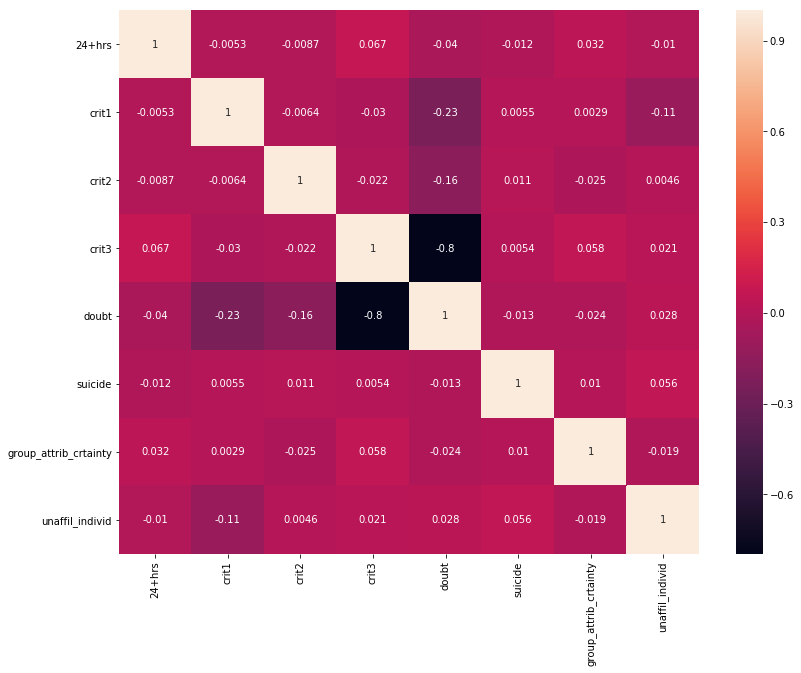

In [298]:
f, ax = plt.subplots(figsize = (13, 10))
sns.heatmap(cyber_train_X.corr(), annot = True)
plt.show()

#### B. Success Rate for Most Active Groups:

In [299]:
# Most prolific groups:

actives = cyber_train_X['group_name'].value_counts().head(10).drop('Unknown')
mask3 = cyber_train_X['group_name'].map(lambda x: x in actives)
actives_df = cyber_train_X[mask3]

temp_output = cyber_train_Y.loc[actives_df.index]

In [300]:
# Checking to make sure I am right:
beta = pd.Series(temp_output.index != actives_df.index)

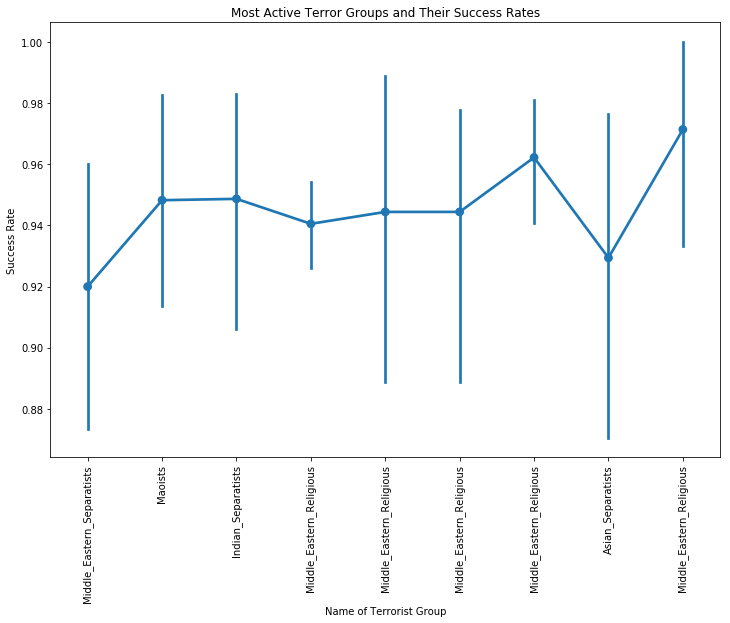

In [301]:
f, ax = plt.subplots(figsize = (12, 8))
sns.pointplot(x = actives_df['group_name'], y = temp_output.success)
ax.set_xticklabels(labels = actives_df['group_name'], rotation = '90')
ax.set_xlabel('Name of Terrorist Group')
ax.set_ylabel('Success Rate')
ax.set_title('Most Active Terror Groups and Their Success Rates')
plt.show()

#### C.  Success Rate In-Country:

In [302]:
# Most Successful Hot-Spots:

hot_countries= cyber_train_X['country_txt'].value_counts().head(10)
mask3 = cyber_train_X['country_txt'].map(lambda x: x in hot_countries)
hot_countries_df = cyber_train_X[mask3]
phi = hot_countries_df['country_txt'].value_counts().head(10)

temp_output2 = cyber_train_Y.loc[hot_countries_df.index]


In [303]:
# Checking to make sure I am right:
beta = pd.Series(temp_output2.index != hot_countries_df.index)
# beta.value_counts()

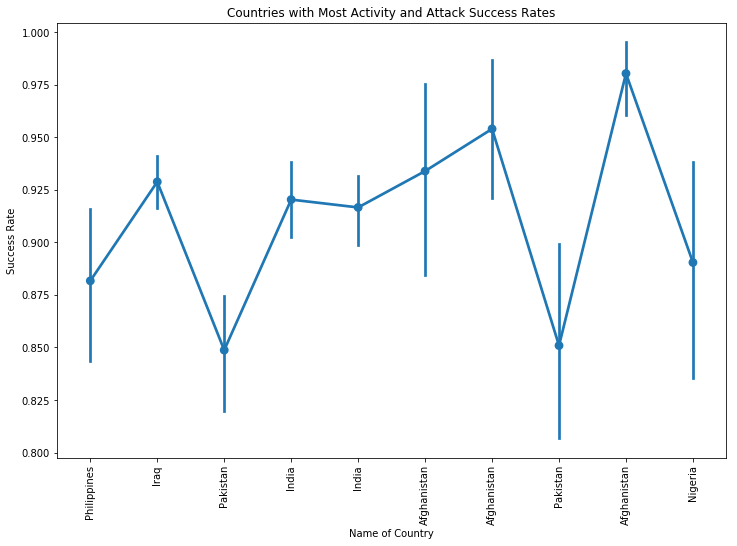

In [304]:
f, ax = plt.subplots(figsize = (12, 8))
sns.pointplot(x = hot_countries_df['country_txt'], y = temp_output2.success)
ax.set_xticklabels(labels = hot_countries_df['country_txt'], rotation = '90')
ax.set_xlabel('Name of Country')
ax.set_ylabel('Success Rate')
ax.set_title('Countries with Most Activity and Attack Success Rates')
plt.show()

### 3. Feature Selection:

> Getting closer to modeling and using feature selection algorithms to see what will help us best minimize our feature set while maintaining the most amount of variation in our dataset.

#### A. Select K-Best:

In [305]:
# Scouting out the null situation:

print(cyber_train_X.shape)
train_nas = cyber_train_X.isna().sum()

print(cyber_test_X.shape)
test_nas = cyber_test_X.isna().sum()

(7114, 19)
(2372, 19)


> Since the null values are relatively few, we will go ahead and drop them from the input dataframes.  This could be better than imputing the mode

##### Assessing Overall DF (cyber_train_dummy_X/Y & cyber_test_dummy_X/Y):

In [306]:
from sklearn import feature_selection

In [374]:
# Getting dummies on our training and test sets (slight wrangling involved):

cyber_train_X.dropna(axis = 0, inplace = True)
cyber_test_X.dropna(axis = 0, inplace = True)

train_index = cyber_train_X.index
test_index = cyber_test_X.index

dummy_prep = pd.concat([cyber_train_X, cyber_test_X]).drop(['group_name', 'city', 'weapontxt'], axis = 1)
dummy_1 = pd.get_dummies(dummy_prep)

# Training/Test Inputs:

cyber_train_dummy_X = dummy_1.loc[train_index]
cyber_test_dummy_X = dummy_1.loc[test_index]

# Training Output:

cyber_train_dummy_Y = cyber_train_Y.loc[train_index]
cyber_test_dummy_Y = cyber_test_Y.loc[test_index]

In [375]:
# Making sure we have the same sizes still:

print(cyber_train_dummy_X.shape)
print(cyber_test_dummy_X.shape)

(6203, 5356)
(2053, 5356)


In [376]:
# Fitting SelectKBest to our Features and output:

KBest_1 = feature_selection.SelectKBest(k = 75) # Had 20, 30, 500 and 700 previously
cyber_train_KBest1 = KBest_1.fit_transform(cyber_train_dummy_X, cyber_train_dummy_Y)

# Transforming the test-set

cyber_test_KBest1 = KBest_1.transform(cyber_test_dummy_X)

In [377]:
# Creating a DF with the top 30 features:

feature_mask = KBest_1.get_support(indices = True)
KBest_1_features = pd.DataFrame(cyber_train_dummy_X.columns[feature_mask])

# Summarizing the scores for those top 30 features in a df:

KBest_1_features['P_Vals'] = KBest_1.pvalues_[0:75]
KBest_1_features['Scores'] = KBest_1.scores_[0:75]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_1_features

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,24+hrs,2.069956e-12,49.617957
1,crit3,2.616864e-01,1.260043
2,doubt,6.304325e-01,0.231498
3,country_txt_Germany,3.876658e-06,21.363322
4,country_txt_Ireland,1.043249e-06,23.894460
5,country_txt_Nepal,2.126913e-01,1.553332
6,country_txt_United Kingdom,2.641037e-01,1.247344
7,region_txt_Western Europe,9.215526e-01,0.009699
8,attack_1txt_Armed Assault,1.027830e-03,10.786990
9,attack_1txt_Assassination,7.647339e-01,0.089571


Pertinent columns:
24 hrs
country_txt / victim nationality
city
attack_1
target_1
sub_target
group_name
sub_weapon

##### Assessing Individual Features:

> Running SelectKBest on a few columns individually to see which of their values is selected as most important:  


> ###### Group_name (name_train_dummy_X/Y & name_test_dummy_X/Y):

In [378]:
# Getting dummies on our training and test sets (slight wrangling involved):

names_train_X = cyber_train_X['group_name']
names_test_X = cyber_test_X['group_name']

names_train_index = cyber_train_X['group_name'].index
names_test_index = cyber_test_X['group_name'].index

names_dummy_prep = pd.concat([names_train_X, names_test_X])
names_dummy_1 = pd.get_dummies(names_dummy_prep)

# Training/Test Inputs:

names_train_dummy_X = names_dummy_1.loc[names_train_index]
names_test_dummy_X = names_dummy_1.loc[names_test_index]

# Training Output:

names_train_dummy_Y = cyber_train_Y.loc[names_train_index]
names_test_dummy_Y = cyber_test_Y.loc[names_test_index]

In [379]:
# Fitting model to our features and output.

KBest_names = feature_selection.SelectKBest(k = 75)  # Tried 30, 50 and 150
names_train_KBest = KBest_names.fit_transform(names_train_dummy_X, names_train_dummy_Y)

# Transforming our test set.

names_test_KBest = KBest_names.transform(names_test_dummy_X)

In [380]:
# Summarizing the scores for those top 30 features in a df:

names_mask = KBest_names.get_support(indices = True)
KBest_names_features = pd.DataFrame(names_train_dummy_X.columns[names_mask])

KBest_names_features['P_Vals'] = KBest_names.pvalues_[0:75]
KBest_names_features['Scores'] = KBest_names.scores_[0:75]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_names_features   

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,African_Political,NaN,NaN
1,African_Religious,7.647339e-01,0.089571
2,Al-Aqsa Martyrs Brigade,7.647339e-01,0.089571
3,Ansar al-Sunna,NaN,NaN
4,Anti-White extremists,7.647339e-01,0.089571
5,Armed Commandos of Liberation,7.647339e-01,0.089571
6,Aryan Republican Army,NaN,NaN
7,Asian_Separatists,6.721000e-01,0.179173
8,Besi Merah Putih Militia,NaN,NaN
9,Black Liberation Army,7.647339e-01,0.089571


Pertinent groups:
African - Religious
Irish
Middle_easter religious
India

> ###### City (city_train_dummy_X/Y & city_test_dummy_X/Y):

In [381]:
# Getting dummies on our training and test sets (slight wrangling involved):

city_train_X = cyber_train_X['city']
city_test_X = cyber_test_X['city']

city_train_index = cyber_train_X['city'].index
city_test_index = cyber_test_X['city'].index

city_dummy_prep = pd.concat([city_train_X, city_test_X])
city_dummy_1 = pd.get_dummies(city_dummy_prep)

# Training/Test Inputs:

city_train_dummy_X = city_dummy_1.loc[city_train_index]
city_test_dummy_X = city_dummy_1.loc[city_test_index]

# Training Output:

city_train_dummy_Y = cyber_train_Y.loc[city_train_index]
city_test_dummy_Y = cyber_test_Y.loc[city_test_index]

In [382]:
# Fitting model to our features and output.

KBest_city = feature_selection.SelectKBest(k = 75) # Tried 30 and 150
city_train_KBest = KBest_city.fit_transform(city_train_dummy_X, city_train_dummy_Y)

# Transforming our test set:

city_test_KBest = KBest_city.transform(city_test_dummy_X)

In [383]:
# Summarizing the scores for those top 30 features in a df:
pd.set_option('max_rows', 101)
city_mask = KBest_city.get_support(indices = True)
KBest_city_features = pd.DataFrame(city_train_dummy_X.columns[city_mask])

KBest_city_features['P_Vals'] = KBest_city.pvalues_[0:75]
KBest_city_features['Scores'] = KBest_city.scores_[0:75]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_city_features   

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,Aguada,NaN,NaN
1,Antrim,7.647339e-01,0.089571
2,Baharak district,NaN,NaN
3,Belauri,7.647339e-01,0.089571
4,Belfast,7.647339e-01,0.089571
5,Chukitong,7.647339e-01,0.089571
6,Dhaka,9.798870e-01,0.000636
7,Doaba,7.647339e-01,0.089571
8,Dublin,NaN,NaN
9,Faizabad,7.647339e-01,0.089571


western sites/cities
ireland
Asia
Afghanistan

> ###### Weapontxt (weapon_train_dummy/weapon_train_output2):

In [384]:
# Getting dummies on our training and test sets (slight wrangling involved):

weapon_train_X = cyber_train_X['weapontxt']
weapon_test_X = cyber_test_X['weapontxt']

weapon_train_index = cyber_train_X['weapontxt'].index
weapon_test_index = cyber_test_X['weapontxt'].index

weapon_dummy_prep = pd.concat([weapon_train_X, weapon_test_X])
weapon_dummy_1 = pd.get_dummies(weapon_dummy_prep)

# Training/Test Inputs:

weapon_train_dummy_X = weapon_dummy_1.loc[weapon_train_index]
weapon_test_dummy_X = weapon_dummy_1.loc[weapon_test_index]

# Training Output:

weapon_train_dummy_Y = cyber_train_Y.loc[weapon_train_index]
weapon_test_dummy_Y = cyber_test_Y.loc[weapon_test_index]

In [385]:
# Fitting the model to our features and training output:

KBest_weapon = feature_selection.SelectKBest(k = 3) # Tried 5
weapon_train_KBest = KBest_weapon.fit_transform(weapon_train_dummy_X, weapon_train_dummy_Y)

# Transforming our test set:

weapon_test_KBest = KBest_weapon.transform(weapon_test_dummy_X)

In [386]:
# Summarizing the scores for those top 5 features in a df:

weapon_mask = KBest_weapon.get_support(indices = True)
KBest_weapon_features = pd.DataFrame(weapon_train_dummy_X.columns[weapon_mask])

KBest_weapon_features['P_Vals'] = KBest_weapon.pvalues_[0:3]
KBest_weapon_features['Scores'] = KBest_weapon.scores_[0:3]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_weapon_features   

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,Explosives,3.146306e-02,4.629618
1,Incendiary,6.404691e-11,42.843590
2,Melee,5.623508e-04,11.909027


top 3:  
Bio-chem
Explosives
Fake/Other

#### B. Principle Component Analysis:

> ##### Assessing Overall DF (cyber_train/test_PCA):

In [387]:
from sklearn.decomposition import PCA

# Using the whole dataset (cyber_train_data):

PCA_1 = PCA(n_components = 75)  # Tried 30 and 500
cyber_train_PCA = PCA_1.fit_transform(cyber_train_dummy_X) # No y. 
cyber_test_PCA = PCA_1.transform(cyber_test_dummy_X)

PCA_1_df = pd.DataFrame(data = PCA_1.singular_values_)
PCA_1_df['Explained_Variance'] = PCA_1.explained_variance_
PCA_1_df['Explained_Variance_Ratio'] = PCA_1.explained_variance_ratio_
PCA_1_df['Noise_Variance'] = PCA_1.noise_variance_
PCA_1_df = PCA_1_df.rename(columns = {0:'Singular_Vals'})


> ##### Assessing Individual Features

> ###### Group_name (names_train/test_PCA):

In [388]:
# Now looking at group_name stuffs:

PCA_name = PCA(n_components = 75) # Tried 30 and 150
name_train_PCA = PCA_name.fit_transform(names_train_dummy_X)
name_test_PCA = PCA_name.transform(names_test_dummy_X)

PCA_name_df = pd.DataFrame(data = PCA_name.singular_values_)
PCA_name_df['Explained_Variance'] = PCA_name.explained_variance_
PCA_name_df['Explained_Variance_Ratio'] = PCA_name.explained_variance_ratio_
PCA_name_df['Noise_Variance'] = PCA_name.noise_variance_
PCA_name_df = PCA_name_df.rename(columns = {0:'Singular_Vals'})

> ###### City (PCA_cities_input:

In [389]:
# Then some city stuff:

PCA_cities = PCA(n_components = 75) # Tried 30 and 150
cities_train_PCA = PCA_cities.fit_transform(city_train_dummy_X)
cities_test_PCA = PCA_cities.transform(city_test_dummy_X)

PCA_cities_df = pd.DataFrame(PCA_cities.singular_values_)
PCA_cities_df['Explained_Variance'] = PCA_cities.explained_variance_
PCA_cities_df['Explained_Variance_Ratio'] = PCA_cities.explained_variance_ratio_
PCA_cities_df['Noise_Variance'] = PCA_cities.noise_variance_
PCA_cities_df = PCA_cities_df.rename(columns = {0:'Singular_Vals'})

> ###### Weapontxt (PCA_weapon_input):

In [390]:
# Group_subweapon:

PCA_weapon = PCA(n_components = 3)  # Tried 5
weapon_train_PCA = PCA_weapon.fit_transform(weapon_train_dummy_X)
weapon_test_PCA = PCA_weapon.transform(weapon_test_dummy_X)

# Summarizing the scores for those top 30 features in a df:

PCA_weapon_df = pd.DataFrame(PCA_weapon.singular_values_)
PCA_weapon_df['Explained_Variance'] = PCA_weapon.explained_variance_
PCA_weapon_df['Explained_Variance_Ratio'] = PCA_weapon.explained_variance_ratio_
PCA_weapon_df['Noise_Variance'] = PCA_weapon.noise_variance_ 
PCA_weapon_df = PCA_weapon_df.rename(columns = {0:'Singular_Vals'})

#### C. Creating Specified DF with Selected Features:

> ##### DataFrame from KBest Algorithims (KBest_train/test_X/Y):

In [391]:
# Training:

alpha = pd.DataFrame(cyber_train_KBest1, columns = KBest_1_features[0])
beta = pd.DataFrame(names_train_KBest, columns = KBest_names_features[0])
gamma = pd.DataFrame(city_train_KBest, columns = KBest_city_features[0])
delta = pd.DataFrame(weapon_train_KBest, columns = KBest_weapon_features[0])

KBest_train_X = pd.concat([alpha, beta, gamma, delta], axis = 1)

In [392]:
alpha2 = pd.DataFrame(cyber_test_KBest1, columns = KBest_1_features[0])
beta2 = pd.DataFrame(names_test_KBest, columns = KBest_names_features[0])
gamma2 = pd.DataFrame(city_test_KBest, columns = KBest_city_features[0])
delta2 = pd.DataFrame(weapon_test_KBest, columns = KBest_weapon_features[0])

KBest_test_X = pd.concat([alpha2, beta2, gamma2, delta2], axis = 1)

> ##### DataFrame from PCA (PCA_train/test_X/Y):

In [393]:
cyber_train_PCA = pd.DataFrame(cyber_train_PCA)
name_train_PCA = pd.DataFrame(name_train_PCA)
cities_train_PCA = pd.DataFrame(cities_train_PCA)
weapon_train_PCA = pd.DataFrame(weapon_train_PCA)

PCA_train_X = pd.DataFrame()
PCA_train_X = pd.concat([cyber_train_PCA, name_train_PCA, cities_train_PCA, weapon_train_PCA], axis = 1)
PCA_train_X.keys()

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            68, 69, 70, 71, 72, 73, 74,  0,  1,  2],
           dtype='int64', length=228)

In [394]:
cyber_test_PCA = pd.DataFrame(cyber_test_PCA)
name_test_PCA = pd.DataFrame(name_test_PCA)
cities_test_PCA = pd.DataFrame(cities_test_PCA)
weapon_test_PCA = pd.DataFrame(weapon_test_PCA)

PCA_test_X = pd.DataFrame()
PCA_test_X = pd.concat([cyber_test_PCA, name_test_PCA, cities_test_PCA, weapon_test_PCA], axis = 1)

### 4. Preliminary Models:

> Starting with a simple Logistic Regression since our output feature is binary.

#### Logistic Regression:

##### KBest Features:

In [471]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import cross_val_score

KBest_logistic = LogisticRegression()

KBest_logistic = KBest_logistic.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_logistic_train_pred_ = KBest_logistic.predict(KBest_train_X)
KBest_logistic_test_pred_ = KBest_logistic.predict(KBest_test_X)

# Evaluation:
  # Confustion Matrices:    
KBest_logistic_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_logistic_train_pred_, labels = [0, 1])
KBest_logistic_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_logistic_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
KBest_logistic_cv = cross_val_score(KBest_logistic, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_logistic_train_score = KBest_logistic.score(KBest_train_X, cyber_train_dummy_Y)
KBest_logistic_test_score = KBest_logistic.score(KBest_test_X, cyber_test_dummy_Y)

  # Looking at balanced accuracy/f1 scores:
KBest_logistic_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_logistic_train_pred_)    
KBest_logistic_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_logistic_test_pred_)    

In [472]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_logistic_cv.mean(),
                                                                     plusminus, KBest_logistic_cv.std()))
print("The cv scores are: {}".format(KBest_logistic_cv))

conf_df = pd.DataFrame(KBest_logistic_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(KBest_logistic_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(KBest_logistic_train))

conf_df2 = pd.DataFrame(KBest_logistic_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(KBest_logistic_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(KBest_logistic_test))


The mean cross-validation score is: 93.89% ±0.35%
The cv scores are: [0.94037067 0.94278807 0.93473006 0.94193548 0.93467742]

Training-Set Metrics:
The training score is: 94.47%

     0     1
0  224   286
1   57  5636

False Positive/Type I Error: 286 (56.08%)
False Negative/Type II Error: 57 (1.00%)
Balanced Accuracy: 71.46%

Test-Set Metrics:
The test score is: 93.72%

    0     1
0  58   110
1  19  1866

False Positive/Type I Error: 110 (65.48%)
False Negative/Type II Error: 19 (1.01%)
Balanced Accuracy: 66.76%


##### PCA Features:

In [469]:
PCA_logistic = LogisticRegression()

PCA_logistic = PCA_logistic.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_logistic_train_pred_ = PCA_logistic.predict(PCA_train_X)
PCA_logistic_test_pred_ = PCA_logistic.predict(PCA_test_X)

# Evaluation:
  # Confustion Matrices:    
PCA_logistic_confusion_train = confusion_matrix(cyber_train_dummy_Y, PCA_logistic_train_pred_, labels = [0, 1])
PCA_logistic_confusion_test = confusion_matrix(cyber_test_dummy_Y, PCA_logistic_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
PCA_logistic_cv = cross_val_score(PCA_logistic, PCA_train_X, cyber_train_dummy_Y, cv = 5)
PCA_logistic_train_score = PCA_logistic.score(PCA_train_X, cyber_train_dummy_Y)
PCA_logistic_test_score = PCA_logistic.score(PCA_test_X, cyber_test_dummy_Y)

  # Looking at balanced accuracy/f1 scores:
PCA_logistic_train = balanced_accuracy_score(cyber_train_dummy_Y, PCA_logistic_train_pred_)    
PCA_logistic_test = balanced_accuracy_score(cyber_test_dummy_Y, PCA_logistic_test_pred_)    

In [470]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_logistic_cv.mean(),
                                                                     plusminus, PCA_logistic_cv.std()))
print("The cv scores are: {}".format(PCA_logistic_cv))

conf_df = pd.DataFrame(PCA_logistic_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(PCA_logistic_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_logistic_train))

conf_df2 = pd.DataFrame(PCA_logistic_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(PCA_logistic_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_logistic_test))


The mean cross-validation score is: 93.07% ±0.28%
The cv scores are: [0.92908944 0.92989525 0.92908944 0.93629032 0.92903226]

Training-Set Metrics:
The training score is: 93.92%

     0     1
0  196   314
1   63  5630

False Positive/Type I Error: 314 (61.57%)
False Negative/Type II Error: 63 (1.11%)
Balanced Accuracy: 68.66%

Test-Set Metrics:
The test score is: 93.42%

    0     1
0  58   110
1  25  1860

False Positive/Type I Error: 110 (65.48%)
False Negative/Type II Error: 25 (1.33%)
Balanced Accuracy: 66.60%


Now, while we do have some decent scores here, especially regarding the true positive predictions, we do have a class imbalance issue we will need to take into consideration (as demonstrated below).  One way of doing that will work on increasing the accuracy of our true negatives and focusing less on our true positives. 

In [332]:
print(cyber_train_dummy_Y.success.value_counts())
print(cyber_test_dummy_Y.success.value_counts())

1    5693
0     510
Name: success, dtype: int64
1    1885
0     168
Name: success, dtype: int64


#### Random Forest:

##### KBest Features:

In [468]:
from sklearn.ensemble import RandomForestClassifier

KBest_forest = RandomForestClassifier(n_estimators = 30, max_depth = 12)

KBest_forest = KBest_forest.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_forest_train_pred_ = KBest_forest.predict(KBest_train_X)
KBest_forest_test_pred_ = KBest_forest.predict(KBest_test_X)

# Evaluation:
  # Confustion Matrices:    
KBest_forest_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_forest_train_pred_, labels = [0, 1])
KBest_forest_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_forest_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
KBest_forest_cv = cross_val_score(KBest_forest, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_forest_train_score = KBest_forest.score(KBest_train_X, cyber_train_dummy_Y)
KBest_forest_test_score = KBest_forest.score(KBest_test_X, cyber_test_dummy_Y)

  # Looking at balanced accuracy/f1 scores:
KBest_forest_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_forest_train_pred_)    
KBest_forest_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_forest_test_pred_)    
    

In [474]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_forest_cv.mean(),
                                                                     plusminus, KBest_forest_cv.std()))
print("The cv scores are: {}".format(KBest_forest_cv))

conf_df = pd.DataFrame(KBest_forest_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(KBest_forest_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(KBest_forest_train))

conf_df2 = pd.DataFrame(KBest_forest_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(KBest_forest_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(KBest_forest_test))

print('\n\nFeature Importances:\n')
feat_imp = pd.DataFrame(KBest_forest.feature_importances_.round(2), index = KBest_train_X.columns, 
                        columns = ["Importances"])
display(feat_imp.sort_values('Importances', ascending = False))


The mean cross-validation score is: 93.76% ±0.45%
The cv scores are: [0.93634166 0.94117647 0.92989525 0.94274194 0.93790323]

Training-Set Metrics:
The training score is: 94.36%

     0     1
0  209   301
1   49  5644

False Positive/Type I Error: 301 (59.02%)
False Negative/Type II Error: 49 (0.86%)
Balanced Accuracy: 70.06%

Test-Set Metrics:
The test score is: 93.72%

    0     1
0  56   112
1  17  1868

False Positive/Type I Error: 112 (66.67%)
False Negative/Type II Error: 17 (0.90%)
Balanced Accuracy: 66.22%


Feature Importances:



,Importances
0,
attack_1txt_Assassination,0.24
target_1txt_Military,0.18
Explosives,0.06
attack_1txt_Bombing/Explosion,0.03
sub_targettxt_Gov_Figure1,0.02
country_txt_Ireland,0.02
target_1txt_Private Citizens & Property,0.02
Unknown,0.02
sub_weapontxt_Unknown Gun Type,0.02


##### PCA Features

In [477]:
PCA_forest = RandomForestClassifier()

PCA_forest = PCA_forest.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_forest_train_pred_ = PCA_forest.predict(PCA_train_X)
PCA_forest_test_pred_ = PCA_forest.predict(PCA_test_X)

# Evaluation:
  # Confusion Matrices:
PCA_forest_confusion_train = confusion_matrix(cyber_train_dummy_Y, PCA_forest_train_pred_, labels = [0, 1])
PCA_forest_confusion_test = confusion_matrix(cyber_test_dummy_Y, PCA_forest_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
PCA_forest_cv = cross_val_score(PCA_forest, PCA_train_X, cyber_train_dummy_Y, cv = 5)
PCA_forest_train_score = PCA_forest.score(PCA_train_X, cyber_train_dummy_Y)
PCA_forest_test_score = PCA_forest.score(PCA_test_X, cyber_test_dummy_Y)

  # Looking and balanced accuracy/f1 scores:
PCA_forest_train = balanced_accuracy_score(cyber_train_dummy_Y, PCA_forest_train_pred_)    
PCA_forest_test = balanced_accuracy_score(cyber_test_dummy_Y, PCA_forest_test_pred_)    

In [478]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_forest_cv.mean(),
                                                                     plusminus, PCA_forest_cv.std()))
print("The cv scores are: {}".format(PCA_forest_cv))

conf_df = pd.DataFrame(PCA_forest_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(PCA_forest_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_forest_train))

conf_df2 = pd.DataFrame(PCA_forest_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(PCA_forest_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_forest_test))



The mean cross-validation score is: 92.94% ±0.28%
The cv scores are: [0.92908944 0.92828364 0.93150685 0.93306452 0.925     ]

Training-Set Metrics:
The training score is: 99.24%

     0     1
0  477    33
1   14  5679

False Positive/Type I Error: 33 (6.47%)
False Negative/Type II Error: 14 (0.25%)
Balanced Accuracy: 96.64%

Test-Set Metrics:
The test score is: 93.42%

    0     1
0  60   108
1  27  1858

False Positive/Type I Error: 108 (64.29%)
False Negative/Type II Error: 27 (1.43%)
Balanced Accuracy: 67.14%


#### Support Vector Classifier:

##### KBest Features:

In [481]:
from sklearn.svm import SVC

KBest_SVC = SVC()

KBest_SVC = KBest_SVC.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_SVC_train_pred_ = KBest_SVC.predict(KBest_train_X)
KBest_SVC_test_pred_ = KBest_SVC.predict(KBest_test_X)

# Evaluation:
  # Confusion matrices:
KBest_SVC_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_SVC_train_pred_, labels = [0, 1])
KBest_SVC_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_SVC_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
KBest_SVC_cv = cross_val_score(KBest_SVC, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_SVC_train_score = KBest_SVC.score(KBest_train_X, cyber_train_dummy_Y)
KBest_SVC_test_score = KBest_SVC.score(KBest_test_X, cyber_test_dummy_Y)

  # Looking at balanced accuracy/f1 scores:
KBest_SVC_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_SVC_train_pred_)
KBest_SVC_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_SVC_test_pred_)    

In [482]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_SVC_cv.mean(),
                                                                     plusminus, KBest_SVC_cv.std()))
print("The cv scores are: {}".format(KBest_SVC_cv))

conf_df = pd.DataFrame(KBest_SVC_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(KBest_SVC_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(KBest_SVC_train))

conf_df2 = pd.DataFrame(KBest_SVC_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(KBest_SVC_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(KBest_SVC_test))


The mean cross-validation score is: 91.78% ±0.00%
The cv scores are: [0.91780822 0.91780822 0.91780822 0.91774194 0.91774194]

Training-Set Metrics:
The training score is: 91.78%

   0     1
0  0   510
1  0  5693

False Positive/Type I Error: 510 (100.00%)
False Negative/Type II Error: 0 (0.00%)
Balanced Accuracy: 50.00%

Test-Set Metrics:
The test score is: 91.82%

   0     1
0  0   168
1  0  1885

False Positive/Type I Error: 168 (100.00%)
False Negative/Type II Error: 0 (0.00%)
Balanced Accuracy: 50.00%


##### PCA Features

In [483]:
PCA_SVC = SVC()

PCA_SVC = PCA_SVC.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_SVC_train_pred_ = PCA_SVC.predict(PCA_train_X)
PCA_SVC_test_pred_ = PCA_SVC.predict(PCA_test_X)

# Evaluation:
  # Confusion Matrices:
PCA_SVC_confusion_train = confusion_matrix(cyber_train_dummy_Y, PCA_SVC_train_pred_, labels = [0, 1])
PCA_SVC_confusion_test = confusion_matrix(cyber_test_dummy_Y, PCA_SVC_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
PCA_SVC_cv = cross_val_score(PCA_SVC, PCA_train_X, cyber_train_dummy_Y, cv = 5)
PCA_SVC_train_score = PCA_SVC.score(PCA_train_X, cyber_train_dummy_Y)
PCA_SVC_test_score = PCA_SVC.score(PCA_test_X, cyber_test_dummy_Y)

  # Looking at the F1/balanced accuracy scores:
PCA_SVC_train = balanced_accuracy_score(cyber_train_dummy_Y, PCA_SVC_train_pred_)
PCA_SVC_test = balanced_accuracy_score(cyber_test_dummy_Y, PCA_SVC_test_pred_)

In [484]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_SVC_cv.mean(),
                                                                     plusminus, PCA_SVC_cv.std()))
print("The cv scores are: {}".format(PCA_SVC_cv))

conf_df = pd.DataFrame(PCA_SVC_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(PCA_SVC_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_SVC_train))

conf_df2 = pd.DataFrame(PCA_SVC_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(PCA_SVC_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_SVC_test))


The mean cross-validation score is: 91.78% ±0.00%
The cv scores are: [0.91780822 0.91780822 0.91780822 0.91774194 0.91774194]

Training-Set Metrics:
The training score is: 91.78%

   0     1
0  0   510
1  0  5693

False Positive/Type I Error: 510 (100.00%)
False Negative/Type II Error: 0 (0.00%)
Balanced Accuracy: 50.00%

Test-Set Metrics:
The test score is: 91.82%

   0     1
0  0   168
1  0  1885

False Positive/Type I Error: 168 (100.00%)
False Negative/Type II Error: 0 (0.00%)
Balanced Accuracy: 50.00%


#### Gradient Boosting:

##### KBest Features:

In [485]:
from sklearn.ensemble import GradientBoostingClassifier

KBest_GBC = GradientBoostingClassifier()

KBest_GBC = KBest_GBC.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_GBC_train_pred_ = KBest_GBC.predict(KBest_train_X)
KBest_GBC_test_pred_ = KBest_GBC.predict(KBest_test_X)

# Evaluation:
  # Confusion matrices:    
KBest_GBC_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_GBC_train_pred_, labels = [0, 1])
KBest_GBC_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_GBC_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
KBest_GBC_cv = cross_val_score(KBest_GBC, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_GBC_train_score = KBest_GBC.score(KBest_train_X, cyber_train_dummy_Y)
KBest_GBC_test_score = KBest_GBC.score(KBest_test_X, cyber_test_dummy_Y)

  # Looking at the F1/balanced-accuracy scores:
KBest_GBC_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_GBC_train_pred_)
KBest_GBC_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_GBC_test_pred_)

In [487]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_GBC_cv.mean(),
                                                                     plusminus, KBest_GBC_cv.std()))
print("The cv scores are: {}".format(KBest_GBC_cv))

conf_df = pd.DataFrame(KBest_GBC_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(KBest_GBC_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(KBest_GBC_train))

conf_df2 = pd.DataFrame(KBest_GBC_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(KBest_GBC_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(KBest_GBC_test))

print('\n\nFeature Importances:\n')
feat_imp = pd.DataFrame(KBest_GBC.feature_importances_.round(2), index = KBest_train_X.columns, 
                        columns = ["Importances"])
display(feat_imp.sort_values('Importances', ascending = False))


The mean cross-validation score is: 93.94% ±0.37%
The cv scores are: [0.93875907 0.94278807 0.93311845 0.94354839 0.93870968]

Training-Set Metrics:
The training score is: 94.49%

     0     1
0  223   287
1   55  5638

False Positive/Type I Error: 287 (56.27%)
False Negative/Type II Error: 55 (0.97%)
Balanced Accuracy: 71.38%

Test-Set Metrics:
The test score is: 93.77%

    0     1
0  58   110
1  18  1867

False Positive/Type I Error: 110 (65.48%)
False Negative/Type II Error: 18 (0.95%)
Balanced Accuracy: 66.78%


Feature Importances:



,Importances
0,
attack_1txt_Assassination,0.26
target_1txt_Military,0.23
Explosives,0.15
target_1txt_Private Citizens & Property,0.03
Unknown,0.02
region_txt_Western Europe,0.02
Chukitong,0.01
Thoubal,0.01
specific_target_Polling Station,0.01


##### PCA Features

In [488]:
PCA_GBC = GradientBoostingClassifier()

PCA_GBC = PCA_GBC.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_GBC_train_pred_ = PCA_GBC.predict(PCA_train_X) 
PCA_GBC_test_pred_ = PCA_GBC.predict(PCA_test_X) 

# Evaluation:

  # Confusion matrices:
PCA_GBC_confusion_train = confusion_matrix(cyber_train_dummy_Y, PCA_train_pred_, labels = [0, 1])
PCA_GBC_confusion_test = confusion_matrix(cyber_test_dummy_Y, PCA_test_pred_, labels = [0, 1])

  # Cross_validation and train/test score:
PCA_GBC_cv = cross_val_score(PCA_GBC, PCA_train_X, cyber_train_dummy_Y, cv = 5, scoring = 'f1')
PCA_GBC_train_score = PCA_GBC.score(PCA_train_X, cyber_train_dummy_Y)
PCA_GBC_test_score = PCA_GBC.score(PCA_test_X, cyber_test_dummy_Y)

  # Looking at the F1/balanced accuracy scores:
PCA_GBC_train = balanced_accuracy_score(cyber_train_dummy_Y, PCA_GBC_train_pred_)
PCA_GBC_test = balanced_accuracy_score(cyber_test_dummy_Y, PCA_GBC_test_pred_)

In [489]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_GBC_cv.mean(),
                                                                     plusminus, PCA_GBC_cv.std()))
print("The cv scores are: {}".format(PCA_GBC_cv))

conf_df = pd.DataFrame(PCA_GBC_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(PCA_GBC_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_GBC_train))

conf_df2 = pd.DataFrame(PCA_GBC_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(PCA_GBC_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_GBC_test))


The mean cross-validation score is: 96.52% ±0.23%
The cv scores are: [0.96321939 0.96596295 0.96522112 0.96904557 0.96261281]

Training-Set Metrics:
The training score is: 95.23%

     0     1
0  259   251
1   45  5648

False Positive/Type I Error: 251 (49.22%)
False Negative/Type II Error: 45 (0.79%)
Balanced Accuracy: 75.00%

Test-Set Metrics:
The test score is: 93.42%

    0     1
0  60   108
1  26  1859

False Positive/Type I Error: 108 (64.29%)
False Negative/Type II Error: 26 (1.38%)
Balanced Accuracy: 66.87%


#### Summary of First Models:

> Based on these preliminary results, it looks like our best models are the Random Forest and Gradient Booster.  We will focus on those moving forward. The main thing that needs to be focused on moving forward is the accuracy regarding our negative predictions.  
    
> With out KBest and PCA feature selections set to select the top 30 rows, the best we were able to get was a 57% negative prediction accuracy.  Next, we will try increasing the number of selected rows as well as adding to our classifications in our filtered text columns.
    

### 5. Improving our Scores:

#### Investigating the Data Itself:

> Here, we will want to take poke around at the areas of the data where an attack was unsuccessful (i.e. Success == 0), so as to try and improve our false prediction score.

In [356]:
fails = cyber_data.loc[cyber_data['success'] == 0]
attack_as = cyber_data.loc[cyber_data['attack_1txt'] == 'Assassination']

In [363]:
fails

,event_id,year,month,day,24+hrs,country,country_txt,region,region_txt,region_2,...,group_name,motive,group_attrib_crtainty,unaffil_individ,nperps,weapon,weapontxt,sub_weapon,sub_weapontxt,property
396,200209220001,2002,9,22,0,160,Philippines,5,Southeast Asia,Basilan,...,Abu Sayyaf Group (ASG),Unknown,1.0,0,5.0,5,Firearms,5.0,Unknown Gun Type,0
674,201507150038,2015,7,15,0,160,Philippines,5,Southeast Asia,Basilan,...,Abu Sayyaf Group (ASG),nan,0.0,0,-99.0,6,Explosives,12.0,Remote Trigger,0
693,201510010004,2015,10,1,0,160,Philippines,5,Southeast Asia,Basilan,...,Abu Sayyaf Group (ASG),"The specific motive is unknown; however, sourc...",1.0,0,-99.0,6,Explosives,16.0,Unknown Explosive Type,1
1867,200407020004,2004,7,2,0,155,West Bank and Gaza Strip,10,Middle East & North Africa,West Bank,...,Al-Aqsa Martyrs Brigade,Unknown,0.0,0,1.0,6,Explosives,13.0,Suicide (carried bodily by human being),0
2731,200211280004,2002,11,28,0,104,Kenya,11,Sub-Saharan Africa,Coast,...,Al-Qaida,Unknown,1.0,0,NaN,6,Explosives,11.0,"Projectile (rockets, mortars, RPGs, etc.)",0
2750,200403110005,2004,3,11,0,185,Spain,8,Western Europe,Madrid,...,Al-Qaida,Abu Hafs al-Masri Brigades said that the attac...,1.0,0,NaN,6,Explosives,28.0,Dynamite/TNT,0
2751,200403110006,2004,3,11,0,185,Spain,8,Western Europe,Madrid,...,Al-Qaida,Abu Hafs al-Masri Brigades said that the attac...,1.0,0,NaN,6,Explosives,28.0,Dynamite/TNT,0
2969,201004230003,2010,4,23,0,95,Iraq,10,Middle East & North Africa,Baghdad,...,Al-Qaida in Iraq,The specific motive for the attack is unknown.,1.0,0,-99.0,6,Explosives,16.0,Unknown Explosive Type,-9
3810,201306020010,2013,6,2,0,228,Yemen,10,Middle East & North Africa,Shabwah,...,Al-Qaida in the Arabian Peninsula (AQAP),nan,0.0,0,-99.0,5,Firearms,5.0,Unknown Gun Type,0
4471,200702080009,2007,2,8,0,6,Algeria,10,Middle East & North Africa,Tizi Ouzou,...,Al-Qaida in the Islamic Maghreb (AQIM),Part of an AQLIM campaign to destabilize Alger...,1.0,0,-99.0,6,Explosives,16.0,Unknown Explosive Type,0


In [365]:
fails.describe(include = ['O'])

,country_txt,region_txt,region_2,city,summary,attack_1txt,target_1txt,sub_targettxt,corp1,specific_target,victim_nationalitytxt,group_name,motive,weapontxt,sub_weapontxt
count,885,885,885,883,885,885,885,717,805,882,830,885,885,885,847
unique,55,10,237,528,879,9,16,75,397,616,57,95,167,9,25
top,Iraq,South Asia,Khyber Pakhtunkhwa,Unknown,05/06/2013: Assailants opened fire on the priv...,Bombing/Explosion,Military,"Government Personnel (excluding police, military)",Unknown,Unknown,Iraq,Unknown,nan,Explosives,Unknown Explosive Type
freq,168,382,49,52,3,454,322,124,197,158,164,626,451,696,268
